<h1>Melanoma Detection using CNN : Part-2</h1>
<h2>Modelling and Inference</h2>

---

A typical deep learning pipeline involves the following steps-

1. Preparing the data so that it can be used for training/inference. This involves creating custom datasets/dataloaders so that batches of data can be fed to the model.

\***NOTE**- *A general best practice is to split the training data set into training and validation sets, then training using only the training set at first, while using the validaton set for inference to test the model's performance. This gives a rough idea on how efficiently the model will perform on the test set.*

2. Defining a model that will be used for training/inference. This step involves either using pretrained models, or creating a custom neural network from scratch.

3. Once the model is defined, we need to define helper functions for model training. A typical training epoch involves the following operations-
    * Forward propagation, where we use the model to predict the target values for a given training data. Then we use a criterion (loss function) to compare the predicted values against the actual target values and calculate the total information loss.
    * Back propagation, where we calculate the gradients of the model parameters w.r.t. the total loss, then use an optimizer function to update the weights and biases accordingly.
    * There is also an optional validation step where we evaluate the model performance on the validation data using the updated model parameters.****
---

## Preparing the Dataset
---

In this section, we will define the dataset and dataloaders. Let us begin with importing all the necessary project dependencies.

In [1]:
import os
import torch
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

from PIL import Image

from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid

!pip install torchsummary --quiet

Let's now load the training and testing dataframes.

In [2]:
train_df = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [3]:
test_df = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')
test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


Now that we have loaded the testing and training dataframes, let's create the custom PyTorch dataset objects that will allow us to use the image data with our PyTorch model.

In [4]:
# creating custom pytorch dataset
class ImageDataset(Dataset):
    """Converts the images into a dataset that will allow us to use the image data with our model
    
    Args-
        dataframe- pandas.DataFrame object containing image IDs and labels
        data_dirs- The directory list in which the images are located
        transforms- torchvision.transforms methods to apply transformations on the images
        test- Boolean value, denotes whether the data is training or testing data
    """
    def __init__(self, dataframe, data_dir, transform = None, test = False):
        self.df = dataframe
        self.data_dir = data_dir
        self.transform = transform
        self.test = test
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        if self.test:
            img_name = self.df.loc[idx]['image_name']
        else:
            img_name, label = self.df.loc[idx][['image_name','target']]
            label = torch.tensor(label)
            label = label.unsqueeze(-1)
            
        try:
            img_path = self.data_dir[0] + '/' + img_name + '.jpg'
            img = Image.open(img_path)
        except:
            img_path = self.data_dir[1] + '/' + img_name + '.jpg'
            img = Image.open(img_path)
        
        if self.transform:
            img = self.transform(img)
        if self.test:
            return img 
        else:
            return img, label

In [5]:
transform_1 = transforms.Compose([
    transforms.ToTensor(),
])

Now let us create our datasets.

In [6]:
# path of training data image directory
train_dirs = ['../input/siimisic-melanoma-512x512-resized/train_1/train_1', '../input/siimisic-melanoma-512x512-resized/train_2/train_2']

# path of test data image directory
test_dir = ['../input/siimisic-melanoma-512x512-resized/test/test']

#creating training dataset object
train_dataset = ImageDataset(train_df, train_dirs, transform = transform_1, test = False)

#creating training dataset object
test_dataset = ImageDataset(test_df, test_dir, transform = transform_1, test = True)

Let us test our ImageDataset objects by printing the lengths of both the test set and the training set.

In [7]:
len(train_dataset), len(test_dataset)

(33126, 10982)

Now, let us view some random images from our training and test datasets.

In [8]:
train_dataset[0][1].shape

torch.Size([1])

In [9]:
def image_viewer(dataset, index):
    """Shows image in the dataset at the index that the user provides.
    
    Args-
        dataset- the custom dataset object
        index- index of the image
    Returns-
        None
    """
    label_dict = {0: 'Benign', 1: 'Malignant'}
    try:
        image, label = dataset[index] 
        print('Lesion type:', label_dict[label.squeeze().item()])
    except:
        image = dataset[index]
    
    plt.imshow(image.permute(1,2,0))

Lesion type: Benign


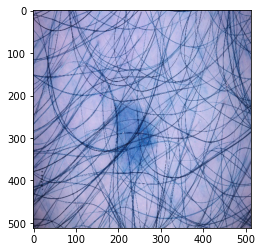

In [10]:
image_viewer(train_dataset, 69)

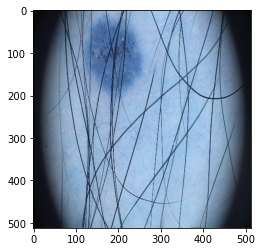

In [11]:
image_viewer(test_dataset, 420)

Now that we know that our datasets are working fine, let us move to the next step. We need to split the training dataset into training and validation datasets. We will keep the validation set around 10% of the complete training dataset.

Also, since the dataset is very large, we will break down the trainig set into 4 parts to ease the training process.

In [12]:
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size

train_ds, val_split_ds = random_split(train_dataset, lengths = [train_size, val_size])

Let us have a look at the number of instances in our training and validation splits.

In [13]:
len(train_ds), len(val_split_ds) 

(29814, 3312)

Now, we need to define a method so that during the training/inference, the data is moved to the CUDA device (Nvidia GPU) in batches instead of all at once. This is very important since our dataset is huge and if we try to move the entire data to the GPU at once, it will run out of memory and we'll run into an error.

In [14]:
batch_size = 64
               
# list of training dataloaders
train_dl = DataLoader(
    dataset = train_ds, 
    batch_size = batch_size, 
    shuffle = True, 
    num_workers = 4, 
    pin_memory = True)  

val_dl = DataLoader(
    dataset = val_split_ds, 
    batch_size = batch_size, 
    shuffle = False, 
    num_workers = 4, 
    pin_memory = True)


We have defined the dataloaders. Now, let's view a batch of data.

In [15]:
def batch_viewer(dataloader):
    """Shows the images in a batch of data
    
    Args-
        dataloader- PyTorch dataloader object
    
    Returns-
        None
    """
    for images, labels in dataloader:
        fig, ax = plt.subplots(figsize = (16,16))
        ax.imshow(make_grid(images, nrow = 8).permute(1, 2, 0))
        break  

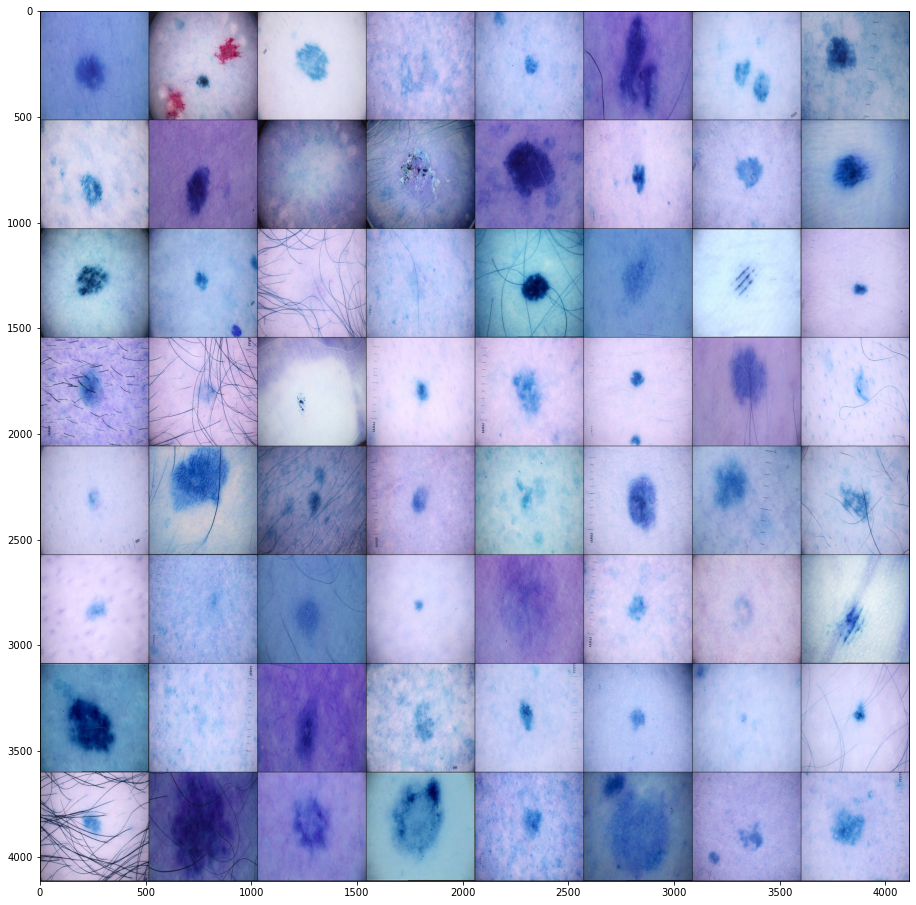

In [16]:
batch_viewer(train_dl)

Now that we have prepared the data for training, we will define our model along with the helper functions required for training and inference.

## Defining the Model

---

In this section, we will define our **model class** along with the **criterion function**, **scoring function** and the various **helper functions** that will come handy while training and evaluating our model.

First, let us create a base class where we will define all the helper functions as well as our loss and accuracy functions. Then we will simply inherit the base class to another class where we will define our actual model.

This will allow us to keep our code clean and modular. Instead of redefining different model functions again and again from scratch for different architectures, we can simply define a new model while our helper functions will remain the same.

In [17]:
def accuracy(output, labels):
    """Calculates the accuracy for the predicted output and the actual label values.
    
    Agrs-
        output- Output tensor generated by the model
        labels- Actual labels for the given batch of data
    
    Returns-
        accuracy- accuracy for the predictions
    """
    labels = labels.squeeze()
    output = output.squeeze()
    return (labels == torch.round(output)).float().sum()/len(labels)
    

class MelanomaClassificationBase(nn.Module):
    def training_step(self, batch):
        """Calculates the cross entropy loss for a given batch of data.
        
        Args-
            batch- One batch of data as generated by the data loader
        
        Returns-
            batch_loss- Total cross entropy loss for the batch
        """
        images, labels = batch 
        output = self(images)
        batch_loss = F.binary_cross_entropy(output.double(), labels.double()) # calculates loss for the predictions and actual labels
        return batch_loss
    
    def validation_step(self, batch):
        """Calculates total validation loss and validation accuracy for a given batch data during a validation step.
        
        Args-
            batch- One batch of data as generated by the data loader
            
        Returns-
            A dictionary object containing validation loss and validation accuracy for the given batch
        """
        images, labels = batch 
        output = self(images)
        batch_loss = F.binary_cross_entropy(output.double(), labels.double())   # calculates batch loss
        batch_acc = accuracy(output, labels)           # calculate batch accuracy
        return {'val_loss': batch_loss.detach(), 'val_acc': batch_acc}
        
    def validation_epoch_end(self, outputs):
        """Calculates mean validation loss and mean validation accuracy for a one validation epoch.
        
        Args-
            outputs- A list of dictionary objects containing validation accuracy and validation loss for each batch of data in one epoch
            
        Returns-
            A dictionary object containing validation loss and validation accuracy for the given batch
        """
        batch_losses = [batch_val_dict['val_loss'] for batch_val_dict in outputs] # creates a list of batch losses for all the batches in one validation epoch
        epoch_loss = torch.stack(batch_losses).mean()   # calculates mean validation loss for the epoch
        batch_accs = [batch_val_dict['val_acc'] for batch_val_dict in outputs]   # creates a list of batch accuracies for all the batches in one validation epoch 
        epoch_acc = torch.stack(batch_accs).mean()      # calculates mean validation accuracy for the epoch
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, 
            result['lrs'][-1], 
            result['train_loss'], 
            result['val_loss'], 
            result['val_acc']))

Now that we have defined the helper functions, let us finally define the model. We are going to use a ResNet34 model that we are going to train from scratch. 

**NOTE**- We are not using a pretrained model since the pretrained model was actually trained on the ImageNet dataset, which is quite a lot different from our data. So the pretrained model parameters will not add much to the model performance.

In [18]:
class MelanomaClassifier(MelanomaClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet34(pretrained=False, progress=False)
        # modifying the last fully-connected layer
        num_ftrs = self.network.fc.in_features 
        self.network.fc = nn.Linear(num_ftrs, 1)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [19]:
model = MelanomaClassifier()
model

MelanomaClassifier(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

## Creating CUDA Wrappers
---
Let us now define a method that allows us to push our model as well as the dataset onto the GPU during the training/testing process. Training on the GPU supports parallalization, processing batches of data at the same time thus increasing the training and inference process. 

In [20]:
def get_default_device():
    """Picks the trainig device-- GPU if available, else CPU.
    """
    if torch.cuda.is_available():   # checks if a cuda device is available
        return torch.device('cuda') # sets the default device as the available CUDA device
    else:
        return torch.device('cpu')  # if no CUDA device found, sets CPU as the default device
    
def to_device(data, device):
    """Move tensor(s) to chosen device
    """
    if isinstance(data, (list,tuple)): # asserts if the data is a list/tuple 
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to the default device.
    """
    def __init__(self, dataloader, device):
        self.dl = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device.
        """
        for batch in self.dl: 
            yield to_device(batch, self.device)

    def __len__(self):
        """Prints the total number of batches.
        """
        return len(self.dl)

With this done, we have successfully defined the method that allows batches of data generated by the dataloader to the CUDA device (our Nvidia GPU).

Now, let us check the default device we have available for the runtime.

In [21]:
device = get_default_device()
device

device(type='cuda')

As we can see, the default device is CUDA. Now, let us move our device and dataloaders onto the default device.

In [22]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

model.to(device, non_blocking=True)

MelanomaClassifier(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

Let us now have a look at the model summary.

In [23]:
from torchsummary import summary

summary(model, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
       BasicBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

With the model and the dataloader moved to the GPU, we will now test the model on a batch of data to make sure everything is working fine before we actually move on to training/inference part. This is like a precautionary step to make sure that we don't run into any major problem while the actual training/inference phase.

We will feed our model with a batch of data from the training dataloader.

* The dimension of the input will be- batch_size x 3 x img_width x img_height
* The output dimension we expect is- batch_size x num_classes(2)

If everything works as expected, we will move on to the final step of our project-- training and evaluating our model.

In [24]:
%%time
def try_batch(dataloader):
    for images, labels in dataloader:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

try_batch(train_dl)

images.shape: torch.Size([64, 3, 512, 512])
out.shape: torch.Size([64, 1])
out[0]: tensor([0.4926], device='cuda:0', grad_fn=<SelectBackward>)
CPU times: user 179 ms, sys: 259 ms, total: 439 ms
Wall time: 7.88 s


## Model Training and Validation
---

As we can see here, everything worked just fine. We will now define the training method.

In [25]:
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()    # sets the model to evaluation mode
    outputs = [model.validation_step(batch) for batch in val_loader] # performs validation for each batch and stores it in a list
    return model.validation_epoch_end(outputs) # returns mean validation accuracy and validation loss for one complete epoch

def get_lr(optimizer):
    """Gets the learning rate of the optimizer.
    """
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay = 0, grad_clip = None, opt_func = torch.optim.SGD):
    
    torch.cuda.empty_cache()    # clears cache in CUDA device
    history = []    # declares an empty list to store result for each epoch
    
    # sets up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)
    
    # sets up one-cycle learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs = epochs, steps_per_epoch = len(train_loader))
    
    for epoch in range(epochs): 
        model.train()    # initiate training phase
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):    # cycles through each batch of the training data
            loss = model.training_step(batch)    
            train_losses.append(loss)
            loss.backward()
            
            # perfomrs gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step() # updates parameters based on gradients obtained via optimizer.backwards()
            optimizer.zero_grad() # resets gradient values
            
            # records & updates learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()
        
        # initaites validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Let us now train the model.

In [27]:
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-3
opt_func = torch.optim.Adam

In [28]:
%%time
history = fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)


Epoch [0], last_lr: 0.00104, train_loss: 0.0924, val_loss: 0.1266, val_acc: 0.9768



Epoch [1], last_lr: 0.00280, train_loss: 0.0844, val_loss: 0.1405, val_acc: 0.9768



Epoch [2], last_lr: 0.00520, train_loss: 0.0857, val_loss: 0.1082, val_acc: 0.9768



Epoch [3], last_lr: 0.00760, train_loss: 0.0852, val_loss: 0.1337, val_acc: 0.9768



Epoch [4], last_lr: 0.00936, train_loss: 0.0855, val_loss: 0.1088, val_acc: 0.9768



Epoch [5], last_lr: 0.01000, train_loss: 0.0839, val_loss: 0.1115, val_acc: 0.9768



Epoch [6], last_lr: 0.00987, train_loss: 0.0844, val_loss: 0.1176, val_acc: 0.9768



Epoch [7], last_lr: 0.00950, train_loss: 0.0857, val_loss: 0.1156, val_acc: 0.9768



Epoch [8], last_lr: 0.00891, train_loss: 0.0835, val_loss: 0.1086, val_acc: 0.9768



Epoch [9], last_lr: 0.00812, train_loss: 0.0819, val_loss: 0.1167, val_acc: 0.9768



Epoch [10], last_lr: 0.00717, train_loss: 0.0811, val_loss: 0.1078, val_acc: 0.9768



Epoch [11], last_lr: 0.00611, train_loss: 0.0820, val_loss: 0.1094, val_acc: 0.9768



Epoch [12], last_lr: 0.00500, train_loss: 0.0809, val_loss: 0.1034, val_acc: 0.9768



Epoch [13], last_lr: 0.00389, train_loss: 0.0805, val_loss: 0.1054, val_acc: 0.9768



Epoch [14], last_lr: 0.00283, train_loss: 0.0801, val_loss: 0.1034, val_acc: 0.9768



Epoch [15], last_lr: 0.00188, train_loss: 0.0802, val_loss: 0.1079, val_acc: 0.9768



Epoch [16], last_lr: 0.00109, train_loss: 0.0799, val_loss: 0.1025, val_acc: 0.9768



Epoch [17], last_lr: 0.00050, train_loss: 0.0786, val_loss: 0.1072, val_acc: 0.9768



Epoch [18], last_lr: 0.00013, train_loss: 0.0781, val_loss: 0.1003, val_acc: 0.9768



Epoch [19], last_lr: 0.00000, train_loss: 0.0778, val_loss: 0.0999, val_acc: 0.9768
CPU times: user 38min 34s, sys: 25min 58s, total: 1h 4min 33s
Wall time: 3h 10min 26s


In [86]:
training_complete = True

## Saving the Model for Later Use

---
Now that we have completed the training, we will save the model state so we can use it later for more training.

In [87]:
torch.save(model.state_dict(), 'melanomaClassification_ResNet34.pth')

## Making predictions & submission

---
Now that the training is complete. let us use the model to make predictions on our test set.

In [88]:
test_dl = DataLoader(
    dataset = test_dataset, 
    batch_size = batch_size, 
    shuffle = False, 
    num_workers = 4, 
    pin_memory = True)

test_dl = DeviceDataLoader(test_dl, device)

Now, we will define the predictor function.

In [89]:
@torch.no_grad()
def predict_dl(test_dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for images in tqdm(test_dl):
        probs = model(images)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return batch_probs

In [90]:
test_preds = predict_dl(test_dl, model)


In [95]:
submission_df = pd.read_csv('../input/siim-isic-melanoma-classification/sample_submission.csv')
submission_df.target = test_preds.numpy()
submission_df.head()

,image_name,target
0,ISIC_0052060,0.009942
1,ISIC_0052349,0.003080
2,ISIC_0058510,0.001688
3,ISIC_0073313,0.001663
4,ISIC_0073502,0.028384


Saving the dataframe to submission CSV.

In [96]:
submission_fname = 'resnet34_submission.csv'
submission_df.to_csv(submission_fname, index=False)

With this, we come to an end of our project. Feel free to use this starter code. Good luck and keep learning!